In [1]:
import imageio.v3 as imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras import layers, models

Loading the class and meta information and setting the training / validation split

In [2]:
classes=pd.read_csv('class_dict.csv') 
meta=pd.read_csv('metadata.csv')
train_meta_df = meta[meta['split'] == 'train']
meta_shuffled = train_meta_df.sample(frac=1).reset_index(drop=True)

# Splitting into training and test sets
train_size = int(0.8 * len(meta_shuffled))
training_meta = meta_shuffled[:train_size]
training_meta.reset_index(drop=True, inplace=True)
validation_meta = meta_shuffled[train_size:]
validation_meta.reset_index(drop=True, inplace=True)

Data generator class for pixelwise mask creating model

In [3]:
class PixelwiseDataset(tf.keras.utils.Sequence):
    def __init__(self, meta, batch_size, classes):
        self.meta = meta
        self.batch_size = batch_size
        self.classes = classes
    
    def __len__(self):
        return math.ceil(len(self.meta) / self.batch_size)

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.meta))
        batch_x = []
        batch_y = []
        
        for i in range(start_idx, end_idx):
            sat_image = imageio.imread(self.meta["sat_image_path"][i]) / 255.0
            mask_image = imageio.imread(self.meta["mask_path"][i])
            
            # Ensure the mask is of the correct shape and dtype
            mask_categorical = np.zeros((2448, 2448), dtype=np.uint8)
            
            # Fill the mask with class labels
            for class_info in self.classes.itertuples():
                target_rgb = (class_info.r, class_info.g, class_info.b)
                target_mask = np.all(mask_image == target_rgb, axis=-1)
                mask_categorical[target_mask] = class_info.Index
            batch_x.append(sat_image)
            batch_y.append(mask_categorical)
        
        return np.array(batch_x), np.array(batch_y)


Custom logging callback for validation and training accuracy / loss

In [4]:
class CustomLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_every=8, val_log=60, val_dataset=None):
        self.log_every = log_every
        self.val_log = val_log
        self.batch_losses = []
        self.batch_accuracies = []
        self.batch_val_loss = []
        self.batch_val_accuracy = []
        self.batches = []
        self.validation_dataset = val_dataset

    def on_batch_end(self, batch, logs=None):
        if batch>0 and batch % self.log_every == 0:
            logs = logs or {}
            loss = logs.get('loss')
            accuracy = logs.get('accuracy')
            self.batch_losses.append(loss)
            self.batch_accuracies.append(accuracy)
            self.batches.append(batch)
            print(f'Batch {batch}: Loss: {loss}, Accuracy: {accuracy}')

        if batch > 0 and batch % self.val_log == 0:
            if self.validation_dataset is not None:
                val_loss, val_accuracy = self.model.evaluate(self.validation_dataset)
                self.batch_val_loss.append(val_loss)
                self.batch_val_accuracy.append(val_accuracy)
                print(f'Validation at batch {batch}: Loss: {val_loss}, Accuracy: {val_accuracy}')


U-net structure model

In [5]:
model = models.Sequential([
    layers.Conv2D(32, (9, 9), padding='same', input_shape=(2448, 2448, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(7, (3, 3), activation='softmax', padding='same')  # Output layer with 7 channels for terrain types
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2448, 2448, 32)    7808      
                                                                 
 batch_normalization (Batch  (None, 2448, 2448, 32)    128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2448, 2448, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 1224, 1224, 32)    0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1224, 1224, 32)    9248      
                                                                 
 batch_normalization_1 (Bat  (None, 1224, 1224, 32)  

Training code where satellite images are called through the dataset generator

In [6]:
batch_size = 1

training_dataset = PixelwiseDataset(training_meta, batch_size, classes)
validation_dataset = PixelwiseDataset(validation_meta, batch_size, classes)
# Creating an instance of the custom callback
custom_logging_callback = CustomLoggingCallback(log_every=150, val_log= 150, val_dataset = validation_dataset)
model.fit(training_dataset, epochs = 3, steps_per_epoch= len(training_dataset), callbacks = [custom_logging_callback])


Epoch 1/3


161/161 [==============================] - 300s 2s/step - loss: 1.3216 - accuracy: 0.5877
Validation at batch 150: Loss: 1.321634292602539, Accuracy: 0.5876994132995605
161/161 [==============================] - 289s 2s/step - loss: 1.2592 - accuracy: 0.5877
Validation at batch 300: Loss: 1.259205937385559, Accuracy: 0.587737500667572
161/161 [==============================] - 292s 2s/step - loss: 1.3432 - accuracy: 0.5954
Validation at batch 450: Loss: 1.343166708946228, Accuracy: 0.5954171419143677
161/161 [==============================] - 290s 2s/step - loss: 3.3270 - accuracy: 0.0981
Validation at batch 600: Loss: 3.326997995376587, Accuracy: 0.09812814742326736
642/642 [==============================] - 3447s 5s/step - loss: 2.9126 - accuracy: 0.1987
Epoch 2/3
161/161 [==============================] - 293s 2s/step - loss: 1.2267 - accuracy: 0.5996
Validation at batch 150: Loss: 1.2266666889190674, Accuracy: 0.5996097326278687
161/161 [==============================] 

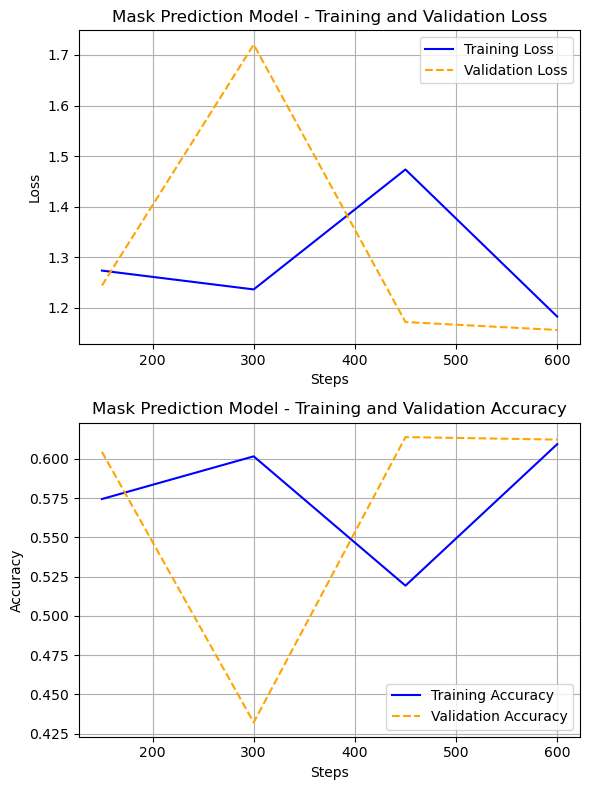

In [7]:
# Retrieving logged data
steps = custom_logging_callback.batches
batch_losses = custom_logging_callback.batch_losses
batch_accuracies = custom_logging_callback.batch_accuracies
batch_val_loss = custom_logging_callback.batch_val_loss
batch_val_accuracy = custom_logging_callback.batch_val_accuracy

# Determining the total number of batches in each epoch
batches_per_epoch = len(steps) // 3  # Assuming you trained for 3 epochs

# Determining the starting index of the last epoch
start_index_last_epoch = batches_per_epoch * 2

# Retrieving the relevant logged data for the last epoch
last_epoch_steps = steps[start_index_last_epoch:]
last_epoch_batch_losses = batch_losses[start_index_last_epoch:]
last_epoch_batch_val_loss = batch_val_loss[start_index_last_epoch:]
last_epoch_batch_accuracies = batch_accuracies[start_index_last_epoch:]
last_epoch_batch_val_accuracy = batch_val_accuracy[start_index_last_epoch:]

# Creating lists to hold all data points
combined_steps = []
combined_losses = []
combined_val_losses = []
combined_accuracies = []
combined_val_accuracies = []

# Iterating over the steps, losses, and accuracies
for step, loss, accuracy in zip(last_epoch_steps, last_epoch_batch_losses, last_epoch_batch_accuracies):
    combined_steps.append(step)
    combined_losses.append(loss)
    combined_accuracies.append(accuracy)

# Iterating over the validation steps, losses, and accuracies
val_step_index = 0
for step, val_loss, val_accuracy in zip(last_epoch_steps, last_epoch_batch_val_loss, last_epoch_batch_val_accuracy):
    # Only include validation metrics at specified intervals
    if step % custom_logging_callback.val_log == 0:
        combined_val_losses.append(val_loss)
        combined_val_accuracies.append(val_accuracy)
    else:
        # Fill with None for steps where validation metrics are not logged
        combined_val_losses.append(None)
        combined_val_accuracies.append(None)


plt.figure(figsize=(6, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(combined_steps, combined_losses, label='Training Loss', color='blue')
plt.plot(combined_steps, combined_val_losses, label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Mask Prediction Model - Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(combined_steps, combined_accuracies, label='Training Accuracy', color='blue')
plt.plot(combined_steps, combined_val_accuracies, label='Validation Accuracy', color='orange', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Mask Prediction Model - Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
model.save("Mask_Predict_FINAL.keras")